### Set Parameters

In [1]:
pf_id = 2 #problem formulation id; should match file name
n_scenarios = pow(2, 10) # Ideally a power of 2 > 1000 ... 2^10 = 1024

### Run Model for Open Exploration

##### Define a nothing policy (necessary for the code to run)

In [2]:
# don't @ me it has to be set up this way to work
from ema_workbench import Policy
policies = [Policy('policy 0', **{'0_RfR 0':0,
                                  '0_RfR 1':0,
                                  '0_RfR 2':0,
                                  'A.1_DikeIncrease 0':0,
                                  'A.1_DikeIncrease 1':0,
                                  'A.1_DikeIncrease 2':0,
                                  '1_RfR 0':0,
                                  '1_RfR 1':0,
                                  '1_RfR 2':0,
                                  'A.2_DikeIncrease 0':0,
                                  'A.2_DikeIncrease 1':0,
                                  'A.2_DikeIncrease 2':0,
                                  '2_RfR 0':0,
                                  '2_RfR 1':0,
                                  '2_RfR 2':0,
                                  'A.3_DikeIncrease 0':0,
                                  'A.3_DikeIncrease 1':0,
                                  'A.3_DikeIncrease 2':0,
                                  '3_RfR 0':0,
                                  '3_RfR 1':0,
                                  '3_RfR 2':0,
                                  'A.4_DikeIncrease 0':0,
                                  'A.4_DikeIncrease 1':0,
                                  'A.4_DikeIncrease 2':0,
                                  '4_RfR 0':0,
                                  '4_RfR 1':0,
                                  '4_RfR 2':0,
                                  'A.5_DikeIncrease 0':0,
                                  'A.5_DikeIncrease 1':0,
                                  'A.5_DikeIncrease 2':0,
                                  'EWS_DaysToThreat':0
                                  })]

##### Import packages


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Import things and set up model (with the selected problem formulation)


In [4]:
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation



ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(pf_id) #changes for each file

In [5]:
(dike_model.outcomes.keys())
#print(dike_model.levers.keys())

odict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])

##### Define uncertainties and levers

In [6]:
import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

##### Run the model with the defined number of scenarios and the nothing policy

In [7]:
from ema_workbench import (ema_logging, MultiprocessingEvaluator, Samplers)
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies, uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 40960 scenarios * 1 policies * 1 model(s) = 40960 experiments
  0%|                                     | 1/40960 [00:05<59:49:18,  5.26s/it]Traceback (most recent call last):
  File "/Users/morris/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/em_framework/callbacks.py", line 246, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/morris/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/em_framework/ema_multiprocessing.py", line 253, in run
    self.callback(*result.get())
  File "/Users/morris/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/em_framework/callbacks.py", line 281, in __call__
    self._store_outcomes(experiment.experiment_id, outcomes)
  File "/Users/morris/opt/anaconda3/lib/python3.8/site-packages/ema_

##### Define experiments and outcome; print names of the outcomes

In [8]:
experiments, outcomes = results
print(outcomes.keys())

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


### Save Results

In [9]:
from ema_workbench import save_results

save_results(results, './output/open_exploration/Open_Exploration_id_%s.tar.gz'%pf_id)

[MainProcess/INFO] results saved successfully to /Users/morris/Desktop/EPA/1st Year Q4/EPA1361 Model-based decision-making/MBDM/final assignment/output/open_exploration/Open_Exploration_id_2.tar.gz


In [10]:
experiments.to_csv('./output/open_exploration/Open_Exploration_id_%s_exp.csv'%pf_id, index=False)
pd.DataFrame.from_dict(outcomes).to_csv('./output/open_exploration/Open_Exploration_id_%s_out.csv'%pf_id, index=False)

### Visualization

##### Import stuff

In [11]:
from ema_workbench.analysis import prim, dimensional_stacking, feature_scoring
from ema_workbench import load_results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Load in previously saved results; can visualize without rerunning the whole notebook

In [12]:
results = load_results('./output/open_exploration/Open_Exploration_id_%s.tar.gz'%pf_id)
experiments, outcomes = results
print(outcomes.keys())

[MainProcess/INFO] results loaded successfully from /Users/morris/Desktop/EPA/1st Year Q4/EPA1361 Model-based decision-making/MBDM/final assignment/output/open_exploration/Open_Exploration_id_2.tar.gz


dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


## Subspace Partitioning

This is where the names of each outcome will need to be fed into the visualizations to get reasonable outputs, ignore this for now or change the names yourself.

#### Outcome: Expected Annual Damage

##### Define x, y, and threshold

In [13]:
x = experiments
data = outcomes["Expected Annual Damage"]
y = data < np.percentile(data, 10) #np.quantile(data, .5)
#data <  np.percentile(data, 10) # not sure how this work, gives better density coverage results?
#quantile

##### Tradeoff density and coverage

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 40960 points remaining, containing 4096 cases of interest
[MainProcess/INFO] mean: 0.9639020197679415, mass: 0.0568115234375, coverage: 0.547607421875, density: 0.9639020197679415 restricted_dimensions: 5


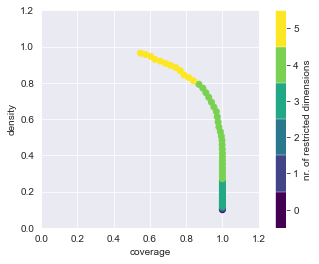

In [14]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

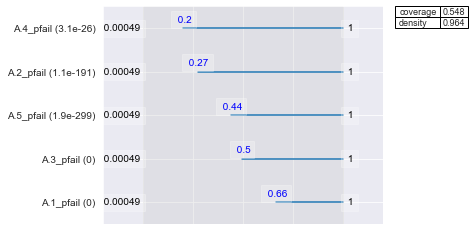

In [15]:
box1.inspect(style='graph')
plt.show()

##### Dimensional stacking

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


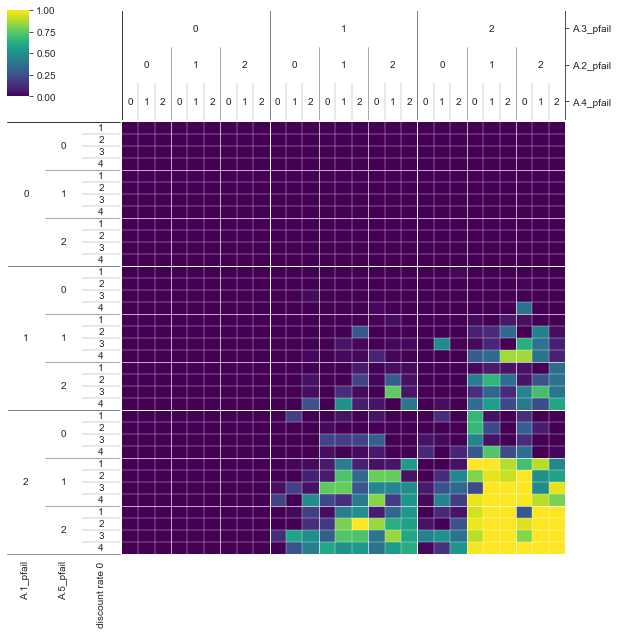

In [16]:
dimensional_stacking.create_pivot_plot(x, y) # 2, nbins=3
plt.show()

##### What this means for us
Scenarios of interest for creating high(?) annual damage are scenarios with high values for:
    A1-5 Pfail and discount rate 0

This may change after running with SOBOL and more scenarios

Also not entierly sure how to pull values for this since the pfail is only supposed to range between 0 and 1 and discount rate is between 1.5 and 4.5

#### Outcome: Expected Number of Deaths

##### Define x, y, and threshold

In [17]:
x = experiments
data = outcomes["Expected Number of Deaths"]
y = data < np.quantile(data, .5) #np.percentile(data, 10) # 10 percent of worst outcomes

##### Tradeoff density and coverage

In [19]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

AssertionError: 

### Sensitivity Analysis

##### As a failsafe, drop NaN outcomes by converting to pandas DataFrame

In [ ]:
outcomes_pd = pd.DataFrame.from_dict(outcomes)
outcomes_pd.dropna(inplace=True)

##### Convert outcomes back into array dict

In [ ]:
outcomes_nonan = outcomes_pd.to_dict('list')

for outcome in outcomes_nonan.keys():
    outcomes_nonan[outcome] = np.array(outcomes_nonan[outcome])

outcomes = outcomes_nonan

##### Drop corresponding runs from experiments

In [ ]:
experiments.drop(list(set(experiments.index) - set(outcomes_pd.index)), inplace=True)

### Feature Scoring

In [ ]:
x = experiments.loc[:,['A.0_ID flood wave shape', 'A.1_pfail', 'A.2_pfail', 'A.3_pfail', 'A.4_pfail', 'A.5_pfail', 'A.1_Bmax', 'A.2_Bmax', 'A.3_Bmax', 'A.4_Bmax', 'A.5_Bmax',  'A.1_Brate', 'A.2_Brate', 'A.3_Brate', 'A.4_Brate', 'A.5_Brate', 'discount rate 0', 'discount rate 1', 'discount rate 2']]
y = outcomes

plt.figure(figsize = (10,7))

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True, )

plt.show()